###  Imports and Configuration

In [1]:
import torch
import jax
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Import the necessary components from our polished codebase ---
from mf_npe.simulator.low_fidelity_hh import NoisyHHSimulator
from mf_npe.simulator.prior import create_prior
from mf_npe.utils.utils import set_global_seed, summarize_voltage, dump_pickle

# ------------------- Configuration -------------------
SEED = 17
SAVE_DIR = Path("./outputs/single_lf_trace/")
SAVE_DIR.mkdir(parents=True, exist_ok=True) # Ensure the output directory exists
OUT_FILE_NPZ = SAVE_DIR / "noisy_ground_truth_trace.npz"
OUT_FILE_PKL = SAVE_DIR / "noisy_ground_truth_trace.pkl"
# -----------------------------------------------------

# Set the seed for reproducibility
key = set_global_seed(SEED)
print(f"Global seed set to {SEED}")

c:\Users\Peter\.jax_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Global seed set to 17


### Define Prior and Sample a Parameter Set

In [2]:
param_ranges = {
    "g_Na":   [50.0, 200.0],
    "g_K":    [20.0, 100.0],
    "g_Leak": [0.1,   1.0],
}

prior = create_prior(param_ranges)
theta_true = prior.sample()

print(f"Sampled ground-truth parameter set (g_Na, g_K, g_L):")
print(theta_true.numpy())

Sampled ground-truth parameter set (g_Na, g_K, g_L):
[82.692345   20.00846     0.22650847]


###  Run the Low-Fidelity Simulator

In [3]:
import time

# Unpack the sampled parameters
gbar_Na, gbar_K, gbar_L = theta_true.tolist()

simulator = NoisyHHSimulator(g_na=gbar_Na, g_k=gbar_K, g_l=gbar_L)

t_array = jax.numpy.arange(0.0, 50.01, 0.01)    #Time

# Run the simulation
print("Running low-fidelity simulation...")
start_time = time.time()
t_out, v_out = simulator.simulate(key=key, t_array=t_array)
elapsed_time = time.time() - start_time
print(f"Simulation finished in {elapsed_time:.4f} seconds.")

Running low-fidelity simulation...
Simulation finished in 0.7619 seconds.


### Summary Statistics

In [4]:
# Convert JAX arrays to NumPy arrays for processing
t_np = np.array(t_out)
v_np = np.array(v_out)

# Calculate the summary statistics
summary_stats = summarize_voltage(t_np, v_np)

print("Calculated Summary Statistics:")
print(f"  Spike Count: {summary_stats[0]}")
print(f"  Mean Rest:   {summary_stats[1]:.2f} mV")
print(f"  Std Rest:    {summary_stats[2]:.2f} mV")
print(f"  Mean Stim:   {summary_stats[3]:.2f} mV")

Calculated Summary Statistics:
  Spike Count: 2.0
  Mean Rest:   -63.39 mV
  Std Rest:    1.85 mV
  Mean Stim:   -49.77 mV


### Save the Results

In [5]:
# Save results in .npz format for general use
np.savez(
    OUT_FILE_NPZ,
    t=t_np,
    V_lo=v_np,
    summary=summary_stats,
    theta=theta_true.numpy(),
    seed=SEED
)
print(f"Saved NPZ results to: {OUT_FILE_NPZ}")

# Save results in .pkl format using our utility
results_dict = {
    "t": t_np,
    "V_lo": v_np,
    "theta_L": theta_true.numpy(),
    "seed": SEED
}
dump_pickle(OUT_FILE_PKL, results_dict)

Saved NPZ results to: outputs\single_lf_trace\noisy_ground_truth_trace.npz
Saved variable to outputs\single_lf_trace\noisy_ground_truth_trace.pkl


### Plot and Save the Voltage Trace

Plot saved successfully to: outputs\single_lf_trace\lf_voltage_trace.png


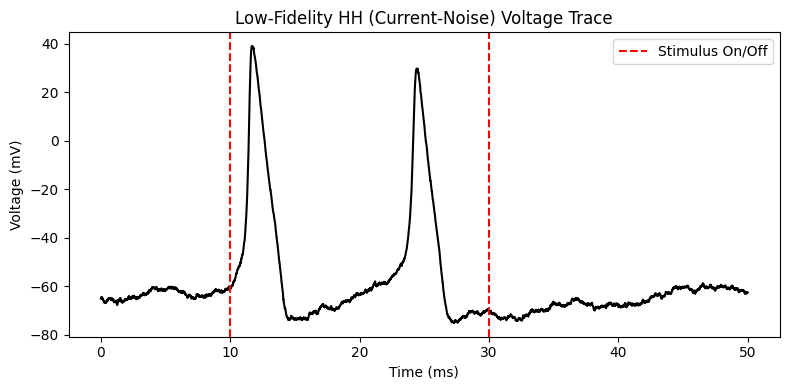

In [7]:
# --- Setup the plot ---
plt.figure(figsize=(8, 4))
plt.plot(t_np, v_np, lw=1.5, color="black")

# Add lines and labels for the stimulus window
plt.axvline(10.0, color="red", linestyle="--", label="Stimulus On/Off")
plt.axvline(30.0, color="red", linestyle="--")

plt.title(f"Low-Fidelity HH (Current-Noise) Voltage Trace")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
# plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

FIGURE_SAVE_PATH = SAVE_DIR / "lf_voltage_trace.png"
plt.savefig(FIGURE_SAVE_PATH, dpi=300, bbox_inches='tight')
print(f"Plot saved successfully to: {FIGURE_SAVE_PATH}")
plt.show()